In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
import random
from scipy.stats import randint


from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas,scikitlearn

Bryan Dickinson 2019-08-07 13:40:47 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0
scikitlearn not installed


### The previous model looked at predicting the race of a subject that had been stopped by an officer, using demographics of both the officer and the subject. 

Can the race of a subject be predicted based on soley on the demographics of the officer?

In [3]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category','subject_race':'category',
                                                'subject_gender': 'category','stop_resolution': 'category',
                                                'weapon_type':'category','initial_call_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

In [4]:
data.head()

,officer_id,officer_age,officer_race,officer_gender,officer_squad,subject_id,subject_age,subject_race,subject_gender,stop_resolution,weapon_type,initial_call_type,call_type,arrest,frisk,precinct,sector,beat
date,,,,,,,,,,,,,,,,,,
2015-03-15,115,60.0,Hispanic or Latino,M,NaN,10305.0,1 - 17,Black,Female,GO for Prosecutorial Referral,Lethal Cutting Instrument,NaN,NaN,0,1.0,NaN,NaN,NaN
2015-03-16,1757,31.0,White,M,NaN,1432.0,18 - 25,Black,Male,Arrest with GO or Supplemental,None,NaN,NaN,1,0.0,NaN,NaN,NaN
2015-03-16,1735,38.0,White,M,NaN,20151.0,36 - 45,Multi-Racial,Male,Street Check,None,NaN,NaN,0,0.0,NaN,NaN,NaN
2015-03-16,1735,38.0,White,M,NaN,22667.0,18 - 25,White,Male,Street Check,None,NaN,NaN,0,0.0,NaN,NaN,NaN
2015-03-17,1735,38.0,White,M,NaN,10743.0,26 - 35,White,Male,Street Check,None,NaN,NaN,0,0.0,NaN,NaN,NaN


In [5]:
def split_mean(x):
    #Function to split the Age bins and return the mean of the two numbers
        if '-' in x:
            split_list = x.split('-')
            mean = (float(split_list[0]) + float(split_list[1]))/2
        else:
            mean = 56
        return mean

In [6]:
#columns to keep
gen_columns = ['officer_race','officer_age','officer_gender','subject_race', 'call_type']

#subset the data
df_general = data[gen_columns]


#remove ambiguous subject_races
df_general = df_general[(df_general.subject_race != 'Unknown') & (df_general.subject_race != 'Other')]

#remove ambiguous officer race 'not specified'
df_general = df_general[df_general.officer_race != 'Not Specified']

# view only stops when the officer initiates the stop
df_general = df_general[df_general.call_type == 'ONVIEW']


#store the category codes of the targer variable for use later
race_cat_codes = dict(enumerate(df_general['subject_race'].cat.categories))

#remove all unused categories
for col in df_general.select_dtypes(include = ['category']).columns:
    df_general[col] = df_general[col].cat.remove_unused_categories()

df_general.drop(['call_type'], axis = 1, inplace = True)  
df_general.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4914 entries, 2015-03-18 to 2019-05-06
Data columns (total 4 columns):
officer_race      4914 non-null category
officer_age       4914 non-null float64
officer_gender    4914 non-null category
subject_race      4914 non-null category
dtypes: category(3), float64(1)
memory usage: 91.8 KB


In [7]:
df_general.head()

,officer_race,officer_age,officer_gender,subject_race
date,,,,
2015-03-18,White,38.0,M,White
2015-03-18,White,38.0,M,White
2015-03-18,White,38.0,M,White
2015-03-18,White,24.0,M,American Indian / Alaskan Native
2015-03-18,White,38.0,M,Black


In [8]:
#columns to keep for individual officer dataframe
ofc_columns = ['officer_id','subject_race', 'call_type']
df_ofc = data[ofc_columns]

# view only stops when the officer initiates the stop
df_ofc = df_ofc[df_ofc.call_type == 'ONVIEW']


df_ofc.drop(['call_type'], axis = 1, inplace = True)

#remove ambiguous subject_races
df_ofc = df_ofc[(df_ofc.subject_race != 'Unknown') & (df_ofc.subject_race != 'Other')]

#remove all unused categories
for col in df_ofc.select_dtypes(include = ['category']).columns:
    df_ofc[col] = df_ofc[col].cat.remove_unused_categories()

df_ofc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5017 entries, 2015-03-18 to 2019-05-06
Data columns (total 2 columns):
officer_id      5017 non-null int64
subject_race    5017 non-null category
dtypes: category(1), int64(1)
memory usage: 83.5 KB


In [9]:
df_ofc.head()

,officer_id,subject_race
date,,
2015-03-18,1735,White
2015-03-18,1735,White
2015-03-18,1735,White
2015-03-18,1827,American Indian / Alaskan Native
2015-03-18,1735,Black


# Build the Classifier
Can the race of a subject be predicted based on soley on the demographics of the officer?

In [10]:
#import relevent classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#import preprocessing, metrics & pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, roc_curve, roc_auc_score


In [11]:
#The metric that will be used is log loss. log loss is a log function is a measure of error. 
#The error should be as small as possible.

def compute_log_loss(predicted, actual, eps = 1e-14):
    #computes the logarithmic loss between predicted and actual when these are 1d arrays
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted)
                       + (1 - actual)
                       * np.log(1-predicted))
    return loss

def consolidate_array(arr, cols = [0,1,2,3,4,5]):
    #function to transform the dummies array to a single column
    
    df = pd.DataFrame(arr, columns = cols)
    return(df.idxmax(axis = 1).values)

In [12]:

#store labels of the target variable
y_1_labels = list(pd.get_dummies(df_general['subject_race']).columns.categories)

#set up the target variable
y_1 = pd.get_dummies(df_general['subject_race']).values


#set the x variables by converting the categorical text features to dummy variables
X_1 = pd.get_dummies(df_general.reset_index(drop = True).drop(['subject_race'], axis = 1),
                          columns = ['officer_race','officer_gender'] ).values



In [13]:
print(y_1.shape)
print(X_1.shape)

(4914, 6)
(4914, 10)


In [14]:
#split the data to test & training sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size = 0.2, 
                                                    random_state = 5, stratify = y_1)


#build the pipline with upsampling & scaling the data
pipeline_1 = imbPipeline([('sm', SMOTE(random_state = 5,
                                     sampling_strategy = 'not majority')),
               ('scale', StandardScaler()),
               ('clf', OneVsRestClassifier(LogisticRegression()))
              ])

#paramters for tuning
parameters_1 = [
    {'clf' : [ OneVsRestClassifier(LogisticRegression(random_state = 5))],
    'clf__estimator__C' : np.logspace(-5, 8, 10),
    'clf__estimator__solver' : ['lbfgs','sag']},
    {'clf' : [ OneVsRestClassifier(RandomForestClassifier(random_state = 5))],
    'clf__estimator__max_depth':[3, 4, None],
    'clf__estimator__n_estimators' :[10,30,100, 120],
    'clf__estimator__max_features' : ['auto', 2, 4]}, 
    {'clf' : [OneVsRestClassifier(KNeighborsClassifier())],
     'clf__estimator__n_neighbors' : [5,10,15]}
]

#create the grid search object
cv_1 = GridSearchCV(pipeline_1,
                    param_grid=parameters_1,
                    cv = 5,
                    scoring = 'neg_log_loss',
                    refit = True,
                    verbose = True,
                    n_jobs = -1)

#fit the data
cv_1.fit(X1_train, y1_train)

Fitting 5 folds for each of 59 candidates, totalling 295 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:  8.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=5, ratio=None,
                                              sampling_strategy='not majority',
                                              svm_estimator='deprecated')),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        One...
                          'clf__estimator__n

In [15]:
cv_1.best_params_

{'clf': OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                      class_weight=None,
                                                      criterion='gini',
                                                      max_depth=4,
                                                      max_features=4,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=10,
                                                      n_jobs=None,
                                   

In [16]:
#predict on the test set
y1_pred = cv_1.predict(X1_test)
#prediction probabilities for each class & observation
y1_predict_proba = cv_1.predict_proba(X1_test)

#create a 1d array of the  six classes corresponding to the original category codes
y1_t = consolidate_array(y1_test)
y1_p = consolidate_array(y1_pred)

In [17]:
#accuracy score
acc_score_1 = cv_1.score(X1_test, y1_test)
log_loss_1 = compute_log_loss(y1_predict_proba, y1_test)
print('The accuracy score is: {}'.format(acc_score_1))
print('The log loss score is: {}'.format(log_loss_1))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y1_t, y1_p))
print(classification_report(y1_t, y1_p))

The accuracy score is: -1.7333446128852532
The log loss score is: 0.4404382645652275
[[ 35   0   0   0   0   1]
 [ 35   0   0   0   0   1]
 [301   0   2   0   0   2]
 [ 56   0   0   0   0   0]
 [ 27   0   0   0   0   1]
 [513   0   0   0   0   9]]
              precision    recall  f1-score   support

           0       0.04      0.97      0.07        36
           1       0.00      0.00      0.00        36
           2       1.00      0.01      0.01       305
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00        28
           5       0.64      0.02      0.03       522

    accuracy                           0.05       983
   macro avg       0.28      0.17      0.02       983
weighted avg       0.65      0.05      0.02       983



C:\Users\Bryan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:

#print the log loss for each column
for col in np.arange(0,6):
    print( compute_log_loss(y1_predict_proba[:,col], y1_test[:,col]), '\t',race_cat_codes[col])

0.23885746853606402 	 American Indian / Alaskan Native
0.24741567170762901 	 Asian
0.671659947787584 	 Black
0.2749099782063282 	 Hispanic
0.21054225874176044 	 Multi-Racial
0.9992442624119994 	 Other


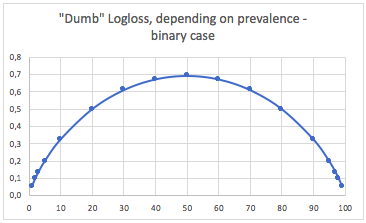
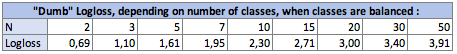

*https://medium.com/@fzammito/whats-considered-a-good-log-loss-in-machine-learning-a529d400632d*

**The model performance metrics:**
 - Log Loss .44
 - Precision .65
 - Recall .02
 - F1 Score .03
 
 The uninformative model will have a log loss of 1.79. The log loss is lower at a .44, however, looking at  classification report, f1 score is low for all classes. The model confidence the vast majority of cases are low (see dataframe below), resulting in a lower log loss score.


In [19]:
# class prediction probabilities
pd.concat([pd.DataFrame(y1_predict_proba), pd.DataFrame(y1_test)], axis = 1).head(10)

,0,1,2,3,4,5,0,1,2,3,4,5
0,0.168862,0.151566,0.176702,0.151239,0.186620,0.160442,0,0,1,0,0,0
1,0.168862,0.151566,0.176702,0.151239,0.186620,0.160442,0,1,0,0,0,0
2,0.168862,0.151566,0.176702,0.151239,0.186620,0.160442,0,0,1,0,0,0
3,0.184983,0.151566,0.183120,0.151239,0.075767,0.160442,0,0,1,0,0,0
4,0.030021,0.038566,0.168207,0.377724,0.056724,0.195646,0,0,0,0,0,1
5,0.143960,0.247430,0.126893,0.072859,0.186620,0.160442,0,0,0,0,0,1
6,0.168862,0.151566,0.176702,0.151239,0.186620,0.160442,0,0,1,0,0,0
7,0.078123,0.071112,0.249382,0.258581,0.106433,0.251037,0,1,0,0,0,0
8,0.182819,0.245271,0.183120,0.151239,0.072561,0.160442,0,0,0,0,0,1
9,0.175109,0.151566,0.183120,0.151239,0.075767,0.160442,0,0,0,0,0,1


In [20]:

#obtain the feature importances from within the GridSearchCV, pipeline, & OneVsRest objects
feat_imp = [x.feature_importances_ for x in cv_1.best_estimator_.steps[2][1].estimators_]
feat_imp = np.mean(feat_imp, axis = 0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(feat_imp,
                                   index = pd.get_dummies(df_general.reset_index(drop = True)
                                                          .drop(['subject_race'], axis = 1),
                                                          columns = ['officer_race','officer_gender'] ).columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(5)

,importance
officer_age,0.450334
officer_race_White,0.138075
officer_gender_M,0.080736
officer_gender_F,0.067232
officer_race_Two or More Races,0.061899


The most important feature importance is officer_age, the model may improve if  officer id is included as a feature into the model. 

# Build the Classifier
Can the race of a subject be predicted by officer?

In [21]:
#subset the data for only officers with 10 or more stops
ls = list(df_ofc.officer_id.value_counts()[df_ofc.officer_id.value_counts() >= 10].index)
df_ofc = df_ofc[df_ofc.officer_id.isin(ls)]

In [22]:
#store the category codes
y_2_labels = list(pd.get_dummies(df_ofc['subject_race']).columns.categories)

#set up the target variable
y_2 = pd.get_dummies(df_ofc['subject_race']).values


#set the x variables by converting the categorical text features to dummy variables
X_2 = pd.get_dummies(df_ofc.reset_index(drop = True).drop(['subject_race'], axis = 1),
                          columns = ['officer_id'] )

In [23]:
print(y_2.shape)
print(X_2.shape)

(3064, 6)
(3064, 149)


In [24]:
#split the data to test & training sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.2, 
                                                    random_state = 5, stratify = y_2)


#build the pipline with upsampling & scaling the data
pipeline_2 = imbPipeline([('sm', SMOTE(random_state = 5, sampling_strategy = 'not majority')),
                        ('scale', StandardScaler()),
                        ('clf', OneVsRestClassifier(LogisticRegression()))
                       ])

#paramters for tuning
parameters_2 = [
    {'clf' : [ OneVsRestClassifier(LogisticRegression(random_state = 5))],
    'clf__estimator__C' : np.logspace(-5, 8, 10),
    'clf__estimator__solver' : ['lbfgs']},
    {'clf' : [ OneVsRestClassifier(RandomForestClassifier(random_state = 5))],
    'clf__estimator__max_depth':[4, 3, None],
     'clf__estimator__criterion': ['gini'],
    'clf__estimator__n_estimators' : [10,25,50,100],
    'clf__estimator__max_features' : ['auto', 2, 4]},
]

#create the grid search object

cv_2 = GridSearchCV(pipeline_2, param_grid = parameters_2,
                    scoring = 'neg_log_loss', 
                    refit = True, 
                    cv = 5, 
                    verbose= True, 
                    n_jobs = -1)


#fit the data
cv_2.fit(X2_train, y2_train)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed: 11.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=5, ratio=None,
                                              sampling_strategy='not majority',
                                              svm_estimator='deprecated')),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        One...
                                            

In [25]:
cv_2.best_estimator_

Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=5, ratio=None,
                       sampling_strategy='not majority',
                       svm_estimator='deprecated')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.007742636826811269,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=None,
                      

In [26]:
#predict on the test set
y2_pred = cv_2.predict(X2_test)

y2_predict_proba = cv_2.predict_proba(X2_test)

y2_t = consolidate_array(y2_test)
y2_p = consolidate_array(y2_pred)

In [27]:
pd.concat([pd.DataFrame(y2_predict_proba), pd.DataFrame(y2_test)], axis = 1).head(10)

,0,1,2,3,4,5,0,1,2,3,4,5
0,0.025878,0.050740,0.735596,0.056479,0.034694,0.148389,0,0,1,0,0,0
1,0.115724,0.109913,0.174274,0.162283,0.227395,0.149103,0,0,1,0,0,0
2,0.025920,0.025488,0.476111,0.030220,0.034757,0.473270,0,0,1,0,0,0
3,0.052338,0.025449,0.296478,0.030171,0.034697,0.617559,0,0,0,0,0,1
4,0.111789,0.107520,0.180806,0.159584,0.228697,0.149060,0,0,0,0,0,1
5,0.112663,0.108412,0.181881,0.161892,0.226043,0.148545,0,0,0,0,0,1
6,0.243081,0.047200,0.053855,0.133026,0.034683,0.518760,0,0,0,0,0,1
7,0.025892,0.514586,0.109057,0.066580,0.034715,0.286529,0,0,0,0,0,1
8,0.025906,0.025475,0.584345,0.088454,0.034736,0.293640,0,0,0,0,0,1
9,0.025900,0.025469,0.651773,0.030196,0.034727,0.298100,0,0,1,0,0,0


In [28]:
#accuracy score
acc_score_2 = cv_2.score(X2_test, y2_test)
log_loss_2 = compute_log_loss(y2_predict_proba, y2_test)
print('The accuracy score is: {}'.format(acc_score_2))
print('The accuracy score is: {}'.format(log_loss_2))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y2_t, y2_p))
print(classification_report(y2_t, y2_p))

The accuracy score is: -1.460800325923693
The accuracy score is: 0.38233743198538017
[[ 15   0   2   0   0   4]
 [ 13   1   1   0   0   6]
 [136   2  26   0   0  25]
 [ 30   1   3   1   0   2]
 [ 16   0   0   0   0   2]
 [200   7  28   0   0  92]]
              precision    recall  f1-score   support

           0       0.04      0.71      0.07        21
           1       0.09      0.05      0.06        21
           2       0.43      0.14      0.21       189
           3       1.00      0.03      0.05        37
           4       0.00      0.00      0.00        18
           5       0.70      0.28      0.40       327

    accuracy                           0.22       613
   macro avg       0.38      0.20      0.13       613
weighted avg       0.57      0.22      0.29       613



C:\Users\Bryan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Findings

**The model performance metrics:**
 - Log Loss .38
 - Precision .57
 - Recall .22
 - F1 Score .29
 
 This model is a small improvement than the previous model, with an increase in accuracy from a .05 to a .22, recall to .22, F1 score to .29. We can see there are more occurences of confident predictions from the model, however, not consistent enough to make any clear predictions.
 
 Adding more relevant features may help to improve the model. Other features may provide some insight when officers determine if an individual warrants a 'stop'. For instance, time of day, neighborhood, initial call information etc.
 
 Additionally creating a clustering model may help categorize / identify any trends amongst groups of officers.